### MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### IMPORT

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
pass

In [ ]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### CONSTANTS

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/SNAMA"

DATA_PATH = os.path.join(PROJECT_DIR, "data")
CHECKPOINTS_PATH = os.path.join(PROJECT_DIR, "checkpoints")
MODELS_PATH = os.path.join(PROJECT_DIR, "models")

PREPROCESSED_DATASET_NAME = "amazon_reviews_preprocessed.pckl"
PREPROCESSED_LABELS_NAME = "amazon_reviews_preprocessed_labels.pckl"

In [ ]:
RANDOM_STATE = 0xd
TEST_SIZE = 0.3

In [ ]:
MAX_LEN = 512
NUM_CLASSES = 0x3

In [ ]:
__LOGICAL_CORES__ = 0x4

### IO

In [ ]:
def dump_object(data, file, directory):
    with open(os.path.join(directory, file), 'wb') as file:
        pickle.dump(data, file)


def load_object(file, directory):
    with open(os.path.join(directory, file), 'rb') as file:
        data = pickle.load(file)
        return data


def exists_object(file, directory):
    return os.path.isfile(os.path.join(directory, file))


def dump_model(data, file, directory=MODELS_PATH):
    dump_object(data, file, directory)


def load_model(file, directory=MODELS_PATH):
    return load_object(file, directory)


def exists_model(file, directory=MODELS_PATH):
    return exists_object(file, directory)


def dump_checkpoint(data, file, directory=CHECKPOINTS_PATH):
    dump_object(data, file, directory)


def load_checkpoint(file, directory=CHECKPOINTS_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=CHECKPOINTS_PATH):
    return exists_object(file, directory)


def load_dataset_from_csv(file, directory=DATA_PATH):
    dataframe_ = pd.read_csv(os.path.join(directory, file))
    return dataframe_.Text.values, dataframe_.Score.values


def dump_dataset(data, file, directory=DATA_PATH):
    dump_object(data, file, directory)


def load_dataset(file, directory=DATA_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=DATA_PATH):
    return exists_object(file, directory)

### PREPROCESSED DATA LOADING

In [ ]:
dataset = load_dataset(PREPROCESSED_DATASET_NAME)
labels = load_dataset(PREPROCESSED_LABELS_NAME)

### TOKENIZATION

In [ ]:
tokenizer = Tokenizer(num_words=MAX_LEN)
tokenizer.fit_on_texts(dataset)

dataset = tokenizer.texts_to_sequences(dataset)
corpus_len = len(tokenizer.word_index) + 0x1

dataset = pad_sequences(dataset, padding="post", maxlen=MAX_LEN)

### MODEL DEFINITION

In [ ]:
def create_model(corpus_len):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=corpus_len,
                               output_dim=128,
                               input_length=MAX_LEN))

    model.add(layers.Flatten())

    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l1_l2(0.01)))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(3, activation='softmax'))
    return model

In [ ]:
model = create_model(corpus_len)

### DATASET SPLITTING

In [ ]:
training_set, test_set, training_labels, test_labels = train_test_split(dataset,
                                                                        labels,
                                                                        test_size=TEST_SIZE,
                                                                        random_state=RANDOM_STATE)

### OPTIMIZER & LOSS

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### TRAINING

In [ ]:
history_object = model.fit(training_set,
                           training_labels,
                           batch_size=64,
                           epochs=150)

Epoch 1/150
2095/2095 [==============================] - 40s 19ms/step - loss: 7.2361 - accuracy: 0.6284
Epoch 2/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3607 - accuracy: 0.6275
Epoch 3/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3748 - accuracy: 0.6266
Epoch 4/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3732 - accuracy: 0.6280
Epoch 5/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3356 - accuracy: 0.6273
Epoch 6/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3403 - accuracy: 0.6269
Epoch 7/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3621 - accuracy: 0.6276
Epoch 8/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3455 - accuracy: 0.6272
Epoch 9/150
2095/2095 [==============================] - 39s 19ms/step - loss: 7.3361 - accuracy: 0.6278
Epoch 10/150
2095/2095 [==============================]

### TEST & PLOTS

In [ ]:
def plot_confusion_matrix(keras_model, data, true_labels, model_name):
    y_pred = np.argmax(model.predict(data), axis=0x1)
    accuracy = accuracy_score(test_labels, y_pred)
    raw_confusion_matrix = confusion_matrix(test_labels, y_pred)
    display = ConfusionMatrixDisplay(raw_confusion_matrix, display_labels=np.unique(test_labels)).plot(cmap="Blues")
    display.ax_.set_title(f"{model_name} Confusion Matrix (Accuracy: {np.round(accuracy, 0x2)})")
    plt.show()

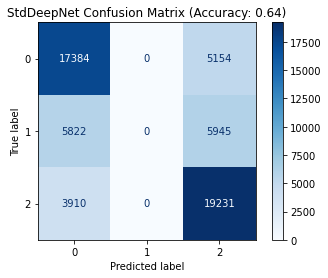

In [ ]:
plot_confusion_matrix(model, test_set, test_labels, "StdDeepNet")

In [ ]:
model.save(os.path.join(MODELS_PATH, "/std_deep_net/std_deep_net_150e_64a.tf"))

INFO:tensorflow:Assets written to: /std_deep_net/std_deep_net_150e_64a.tf/assets
